In [68]:
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, root_mean_squared_error, make_scorer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, Lasso
from lightgbm import LGBMRegressor
import lightgbm as lgb

np.random.seed(3123)

In [3]:
data=pd.read_csv('mimic_train.csv')
mimic_diagnoses_df = pd.read_csv('MIMIC_diagnoses.csv')
test=pd.read_csv('Xtest.csv')

## DATA INSPECTION

/tmp/ipykernel_759659/4050722358.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


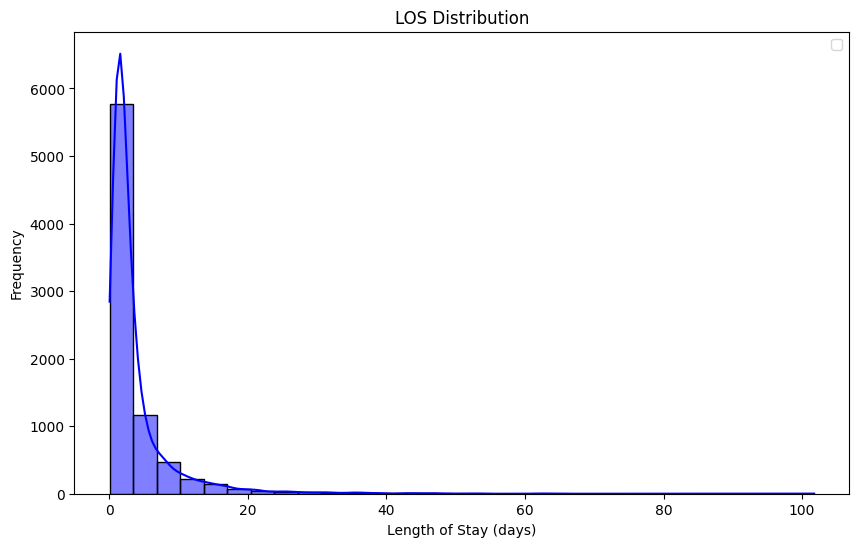

In [4]:
# Histogram of LOS
plt.figure(figsize=(10, 6))
sns.histplot(data['LOS'], bins=30, kde=True, color='blue')
plt.title('LOS Distribution')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

After inspecting the data columns, we define the first task to be an Age variable creation. 

### AGE VARIABLE

In our dataset, we have a column called `DOB` (Date of Birth), which contains the birth dates of the patients. Our objective is to derive an **age group** variable based on the patient's age, which will be used to understand the relationship between age and other variables in predicting the target (e.g., mortality rate).

To do so, we will use the column 'ADMITTIME' (Admission time) and will substract 'DOB' (Date of Birth) to it in order to achieve the Age. 

In [5]:
# Ensure DOB is a string
data['DOB'] = data['DOB'].astype(str)
data['ADMITTIME']=data['ADMITTIME'].astype(str)
test['DOB'] = test['DOB'].astype(str)
test['ADMITTIME']=test['ADMITTIME'].astype(str)

# Extract the first four characters for the year
data['DOB'] = data['DOB'].str[:4].astype(int)
data['ADMITTIME'] = data['ADMITTIME'].str[:4].astype(int)
test['DOB'] = test['DOB'].str[:4].astype(int)
test['ADMITTIME'] = test['ADMITTIME'].str[:4].astype(int)

#Calculate the Age
data['Age']=data['ADMITTIME']-data['DOB']
test['Age']=test['ADMITTIME']-test['DOB']

Now we plot the histogram to visualize the Age distribution

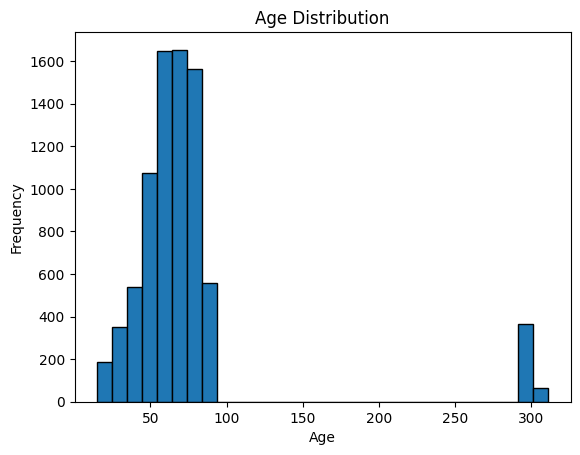

In [6]:
# Plot the histogram
plt.hist(data['Age'], bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

By cheking the MIMIC website, we can see that patients over 89 are given an age of 300. Taking this into consideration, the next step is to change those aged over 300, to age 90

In [7]:
data['Age'] = data['Age'].apply(lambda x: 90 if x > 250 else x)
test['Age'] = test['Age'].apply(lambda x: 90 if x > 250 else x)

Lastly, we categorize our age variable into groups, to dummify our variable and create a larger impact on the final model


In [8]:
# Define the age bins and labels
age_bins = [0, 20, 40, 60, 80, float('inf')]  # Create 5 bins
age_labels = ['0-19', '20-39', '40-59', '60-79', '80+']  # Labels for the bins

# Create a new column for the age category
data['Age_Category'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels, right=False)
test['Age_Category'] = pd.cut(test['Age'], bins=age_bins, labels=age_labels, right=False)

# One-hot encode the Age_Category column to create dummy variables
data = pd.get_dummies(data, columns=['Age_Category'], prefix='Age', drop_first=False)
test = pd.get_dummies(test, columns=['Age_Category'], prefix='Age', drop_first=False)

In [9]:
data.columns

Index(['Unnamed: 0', 'HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id',
       'icustay_id', 'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean',
       'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max',
       'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'GENDER', 'DOB', 'DOD',
       'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'Diff', 'ADMISSION_TYPE',
       'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS',
       'ICD9_diagnosis', 'FIRST_CAREUNIT', 'LOS', 'Age', 'Age_0-19',
       'Age_20-39', 'Age_40-59', 'Age_60-79', 'Age_80+'],
      dtype='object')

One of our objectives will be to reduce the amount of features will keeping a good data explanation. To do so, we will reduce all systolic (heart rate, resp rate, SpO2, etc.) variables to their mean and range.

In [10]:
# List of features to calculate range for
features_to_process = [
    'HeartRate', 'SysBP', 'DiasBP', 'MeanBP', 'RespRate', 'TempC', 'SpO2', 'Glucose'
]

# Loop over each feature to calculate range
for feature in features_to_process:
    min_col = f'{feature}_Min'
    max_col = f'{feature}_Max'
    mean_col = f'{feature}_Mean'
    
    # Calculate the range and mean for each feature
    data[f'{feature}_Range'] = data[max_col] - data[min_col]
    test[f'{feature}_Range'] = test[max_col] - test[min_col]
    
    # Drop the Min and Max columns
    data = data.drop(columns=[min_col, max_col])
    test = test.drop(columns=[min_col, max_col])

Let's inspect some of the variables and how we could encode them.

In [11]:
data['INSURANCE'].unique()

array(['Medicare', 'Private', 'Medicaid', 'Government', 'Self Pay'],
      dtype=object)

Given the different values the variable 'INSURANCE' takes, we can dummify it as we belief type of insurance can have an effect on the Length Of Stay (LOS). However, to reduce the feature number, we will only divide it in Public and Private Insurances.

In [12]:
# Define the grouping logic
public_insurances = ['Medicare', 'Medicaid', 'Government']
private_insurances = ['Private', 'Self Pay']

# Create a new column 'Insurance_Group'
data['Insurance_Group'] = data['INSURANCE'].apply(
    lambda x: 'Public' if x in public_insurances else 'Private'
)
test['Insurance_Group'] = test['INSURANCE'].apply(
    lambda x: 'Public' if x in public_insurances else 'Private'
)
# Dummify the 'Insurance_Group' column
data = pd.get_dummies(data, columns=['Insurance_Group'])
test = pd.get_dummies(test, columns=['Insurance_Group'])

# Rename the dummy column for clarity
data.rename(columns={'Insurance_Group_Private': 'Private_Insurance'}, inplace=True)
test.rename(columns={'Insurance_Group_Private': 'Private_Insurance'}, inplace=True)

Now we drop columns with categorical data that we predict will be of no use (e.g., marital_status, religion, etc.) and certain date columns that don't seem to have apparent use.

In [13]:
data.drop(columns=['Unnamed: 0','DOD', 'Age', 'HOSPITAL_EXPIRE_FLAG', 'INSURANCE',
        'DISCHTIME', 'DEATHTIME', 'Diff', 'ADMISSION_TYPE',
         'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'DOB'],inplace=True)
test.drop(columns=['DOD', 'Age','X',
                   'DISCHTIME', 'DEATHTIME', 'Diff', 'ADMISSION_TYPE', 'INSURANCE',
                    'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS',  'DOB'],inplace=True)

In [14]:
data.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Mean', 'SysBP_Mean',
       'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean', 'TempC_Mean',
       'SpO2_Mean', 'Glucose_Mean', 'GENDER', 'ADMITTIME', 'ICD9_diagnosis',
       'FIRST_CAREUNIT', 'LOS', 'Age_0-19', 'Age_20-39', 'Age_40-59',
       'Age_60-79', 'Age_80+', 'HeartRate_Range', 'SysBP_Range',
       'DiasBP_Range', 'MeanBP_Range', 'RespRate_Range', 'TempC_Range',
       'SpO2_Range', 'Glucose_Range', 'Private_Insurance',
       'Insurance_Group_Public'],
      dtype='object')

After checking the data type of each column  ( to see if we should drop more columns, or dummify some others) with data.dtype, we  decide to convert gender and will further explore first_careunit to check if we could also use it.

In [15]:
data['FIRST_CAREUNIT'].unique()

array(['MICU', 'TSICU', 'CSRU', 'SICU', 'CCU'], dtype=object)

Given that there are only 5 different values in the column, we can easily dummify it to gain some additional information for our regression. Because we will run a KNN later, it is best to dummify categorical values rather than encoding them with single integer values, as we know that KNN relies on distance and could misinterpret 1 closer to 2 than to 5.

In [16]:
# Convert the GENDER column to dummy variables
data_gender = pd.get_dummies(data, columns=['GENDER'], prefix='Gender')
test_gender = pd.get_dummies(test, columns=['GENDER'], prefix='Gender')
# Convert the FIRAST_CAREUNIT column to dummy variables
data_with_dummies = pd.get_dummies(data_gender, columns=['FIRST_CAREUNIT'], prefix='CareUnit')
test_with_dummies = pd.get_dummies(test_gender, columns=['FIRST_CAREUNIT'], prefix='CareUnit')

We must now deal with our most important variable for each patient, its diagnosis. The best approach considered would be to dummify the variable ICD9_diagnosis, but for large datasets with too many different ICD9 values, this would dangerously increase computational time, so we want to avoid it. 

Instead, we target encode ICD9_diagnosis, replacing each unique category with the average target variable for that diagnosis, which will be the length of stay (LOS). For that, we must group the categories and calculate their avergare LOS, to later substitute the icd9_diagnosis category by its LOS.  

In [17]:
# Step 1: Calculate mortality rates for all ICD9 codes
icd9_target_encoding = data_with_dummies.groupby('ICD9_diagnosis')['LOS'].mean()

# Step 2: Map the mortality rates to mimic_diagnoses
data_with_dummies['average_LOS'] = data_with_dummies['ICD9_diagnosis'].map(icd9_target_encoding)
overall_mean=data_with_dummies['average_LOS'].mean()
test_with_dummies['average_LOS'] = test_with_dummies['ICD9_diagnosis'].map(icd9_target_encoding).fillna(overall_mean) # we fill the missing values with the overall mean of average Lengths of Stay

# Step 3: Aggregate by hadm_id to find the max mortality rate for each hadm_id
#max_LOS = data_with_dummies.groupby('hadm_id')['average_LOS'].max()
#test_max_LOS = data_with_dummies.groupby('hadm_id')['average_LOS'].max()

# Step 4: Map the max mortality rate back to data_with_dummies using hadm_id
#data_with_dummies['average_LOS'] = data_with_dummies['hadm_id'].map(max_LOS)
#test_with_dummies['average_LOS'] = data_with_dummies['hadm_id'].map(test_max_LOS)

### Steps followed during target encoding
1. *Group by ICD9_diagnosis*: We first group the data by the ICD9_diagnosis column, which contains the diagnosis codes, and calculate the mean of HOSPITAL_EXPIRE_FLAG for each group. This gives us the average Length of Stay for each unique diagnosis code.

2. *Map the encoding back to the dataset*: We then map these calculated LOS back to the ICD9_diagnosis column in the original dataframe, creating a new column average_LOS.

Finally, we drop the original ICD9_diagnosis, which will be of no more use.



To avoid running into Nans when applying the target encoding technique into the testing dataset, we calculate the overall mean LOS (for the entire training dataset) and apply it to any unrecognised icd9 diagnoses from the testing dataset. 

### SECONDARY DIAGNOSES

Afterwards, we move on the what will likely be some of our most imporant features: **COMORBIDITIES**

This allows us to add some influence on the Length of stay by our seconday diagnosis. We set the primary diagnosis weight to be 0.7, but we also define some dynamic weighting for cases with a LOS of over 4. In such cases it is assumed there is a higher chance of multiple diagnosis adding up to the LOS, therefore more weight is given to seconday diagnosis. 

In [18]:
def encode_comorbidities_aggregate(df_comorbidities, train_df, test_df, target_col='LOS', primary_weight=0.7):
    # Calculate target mean encoding for each ICD9_CODE based on the target in train_df
    comorbidity_target_means = df_comorbidities.merge(
        train_df[['subject_id', 'hadm_id', target_col]],
        left_on=['SUBJECT_ID', 'HADM_ID'],
        right_on=['subject_id', 'hadm_id'],
        how='left'
    ).groupby('ICD9_CODE')[target_col].mean()

    # Map the target encoding back to the comorbidities DataFrame
    df_comorbidities['comorbidity_encoded'] = df_comorbidities['ICD9_CODE'].map(comorbidity_target_means)

    # Replace any missing encodings with the overall target mean
    overall_mean = train_df[target_col].mean()
    df_comorbidities['comorbidity_encoded'] = df_comorbidities['comorbidity_encoded'].fillna(overall_mean)

    # Aggregate encoding statistics for each ICU stay
    comorbidity_aggregates = df_comorbidities.groupby(['SUBJECT_ID', 'HADM_ID']).agg(
        comorbidity_encoded_mean=('comorbidity_encoded', 'mean'),
        comorbidity_encoded_sum=('comorbidity_encoded', 'sum'),
        comorbidity_encoded_max=('comorbidity_encoded', 'max')
    ).reset_index()

    # Merge the aggregated comorbidities back with train and test datasets
    train_df = train_df.merge(comorbidity_aggregates, left_on=['subject_id', 'hadm_id'], right_on=['SUBJECT_ID', 'HADM_ID'], how='left')
    test_df = test_df.merge(comorbidity_aggregates, left_on=['subject_id', 'hadm_id'], right_on=['SUBJECT_ID', 'HADM_ID'], how='left')

    # Fill missing values with 0 for cases with no comorbidities
    train_df[['comorbidity_encoded_mean', 'comorbidity_encoded_sum', 'comorbidity_encoded_max']] = \
        train_df[['comorbidity_encoded_mean', 'comorbidity_encoded_sum', 'comorbidity_encoded_max']].fillna(0)
    test_df[['comorbidity_encoded_mean', 'comorbidity_encoded_sum', 'comorbidity_encoded_max']] = \
        test_df[['comorbidity_encoded_mean', 'comorbidity_encoded_sum', 'comorbidity_encoded_max']].fillna(0)

    # Create the combined encoded column with dynamic weighting based on LOS
    def calculate_combined_encoding(row, primary_weight):
        # Dynamic weighting based on the LOS value for the train set
        if target_col in row:  # Check if LOS is available in the train set
            if row[target_col] < 4:  # If LOS is low (e.g., < 5 days) #ASSUMPTION; if the LOS IS for a few days i predict that is goint to be mainly for the primary diagnoissi, and if the LOS is more than a few days i think that the secondary diagnoisis will have more weight
                primary_weight_dynamic = 0.8
                secondary_weight_dynamic = 0.2
            else:  # If LOS is high
                primary_weight_dynamic = 0.4
                secondary_weight_dynamic = 0.6
        else:  # For the test set, use fixed weights (70% ,30%)
            primary_weight_dynamic = primary_weight
            secondary_weight_dynamic = 1 - primary_weight

        # Calculate combined encoding
        combined_value = (
            primary_weight_dynamic * row['average_LOS'] +  # Primary diagnosis encoding
            secondary_weight_dynamic * row['comorbidity_encoded_mean']  # Secondary diagnosis encoding
        )
        return combined_value

    # Apply the combined encoding to both train and test sets
    train_df['combined_encoded'] = train_df.apply(calculate_combined_encoding, axis=1, primary_weight=primary_weight)
    test_df['combined_encoded'] = test_df.apply(calculate_combined_encoding, axis=1, primary_weight=primary_weight)

    # Drop extra columns from the merge
    train_df = train_df.drop(columns=['SUBJECT_ID', 'HADM_ID'])
    test_df = test_df.drop(columns=['SUBJECT_ID', 'HADM_ID'])

    return train_df, test_df

# Apply aggregate comorbidity encoding and merge to training and testing sets
data_with_dummies, test_with_dummies = encode_comorbidities_aggregate(mimic_diagnoses_df, data_with_dummies, test_with_dummies, target_col='LOS', primary_weight=0.7)

In [19]:
data_with_dummies.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Mean', 'SysBP_Mean',
       'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean', 'TempC_Mean',
       'SpO2_Mean', 'Glucose_Mean', 'ADMITTIME', 'ICD9_diagnosis', 'LOS',
       'Age_0-19', 'Age_20-39', 'Age_40-59', 'Age_60-79', 'Age_80+',
       'HeartRate_Range', 'SysBP_Range', 'DiasBP_Range', 'MeanBP_Range',
       'RespRate_Range', 'TempC_Range', 'SpO2_Range', 'Glucose_Range',
       'Private_Insurance', 'Insurance_Group_Public', 'Gender_F', 'Gender_M',
       'CareUnit_CCU', 'CareUnit_CSRU', 'CareUnit_MICU', 'CareUnit_SICU',
       'CareUnit_TSICU', 'average_LOS', 'comorbidity_encoded_mean',
       'comorbidity_encoded_sum', 'comorbidity_encoded_max',
       'combined_encoded'],
      dtype='object')

### FREQUENCY ENCODING EACH ICD9_DIAGNOSIS

As an additional feature, we also calculate the frequency of each ICD9_diagnosis using the mimic_diagnosis dataframe provided

In [20]:
# Step 1: Calculate the frequency of each ICD9_CODE
icd9_frequency_encoding = mimic_diagnoses_df['ICD9_CODE'].value_counts(normalize=True)

# Step 2: Map the frequencies to mimic_diagnoses
data_with_dummies['ICD9_frequency'] = data_with_dummies['ICD9_diagnosis'].map(icd9_frequency_encoding)
test_with_dummies['ICD9_frequency'] = test_with_dummies['ICD9_diagnosis'].map(icd9_frequency_encoding)


To take the secondary diagnoses into account, we will count how many there are for each hadm_id. This information could be interesting to relate to LOS, as the higher the number the more chances of comorbidities and therefore a longer stay. 

In [21]:
# Count the number of ICD9 diagnoses for each hadm_id
icd9_counts = mimic_diagnoses_df.groupby('HADM_ID')['ICD9_CODE'].count()

# Create a new column to store the counts in the original DataFrame
data_with_dummies['ICD9_count'] = data_with_dummies['hadm_id'].map(icd9_counts)
test_with_dummies['ICD9_count'] = test_with_dummies['hadm_id'].map(icd9_counts)
# Step 5: Drop the original ICD9_diagnosis column if no longer needed
data_with_dummies.drop(columns=['ICD9_diagnosis'], inplace=True, errors='ignore')
test_with_dummies.drop(columns=['ICD9_diagnosis'], inplace=True, errors='ignore')

Now we just inspect some random data to check how everything is going 

In [22]:
data_with_dummies.loc[300:450:10,['hadm_id', 'icustay_id','LOS', 'average_LOS', 'ICD9_frequency','ICD9_count', 'Gender_M', 'ADMITTIME']]

,hadm_id,icustay_id,LOS,average_LOS,ICD9_frequency,ICD9_count,Gender_M,ADMITTIME
300,184199,258359,10.4189,2.868967,0.000407,28,False,2143
310,139239,207141,5.0618,2.371238,0.004495,11,False,2167
320,195776,213542,6.0984,4.370118,0.002100,4,False,2142
330,177455,234151,6.8173,3.477206,0.000465,12,True,2194
340,150138,212907,2.5274,5.064625,0.000576,8,True,2154
350,188225,204322,3.4172,7.341040,0.000221,33,False,2174
360,175305,210837,5.0221,3.495655,0.000257,12,False,2193
370,105803,233062,2.9280,7.334754,0.000135,8,True,2110
380,164710,264891,0.8306,3.168945,0.000657,13,True,2179
390,180017,255594,1.0003,3.158298,0.014008,13,True,2139


Now let's add an additional feature engineering technique better suited to find hidden patterns in 'LOS'. 

I will be ADMITTIME, where we extract the time of the year, the weekday and the hour of admission. In the way, we are hoping to capture temporal trends like "patients admitted in the evening tend to stay longer" or "weekend admissions correlate with shorter LOS" can be learned effectively.

### ADMITTIME EXTRACTION

As we just commented, in this section we dissect the ADMITTIME feature and extract three aditional features:
- Admission month
- Weekend vs Weekday admissions
- Admission Hour and weekday

For the last one, we will use a technique called CYCLICAL ENCODING. Without it, the model would treat 23h and 0h as being far apart, ignoring its adjacence in real time (same effect happens for sundays and mondays). 

To represent this in the model, we use trigonometric functions (sine and cosine).



**NOTE** After a brief inspection on ADMITTIME, we conclude that there is no information on the date of admission, but only the actual time of the day. Therefore, we only proceed with the time extraction

In [23]:
data_with_dummies['ADMITTIME'] = pd.to_datetime(data_with_dummies['ADMITTIME'], errors='coerce')
test_with_dummies['ADMITTIME'] = pd.to_datetime(test_with_dummies['ADMITTIME'], errors='coerce')

In [24]:
data['ADMITTIME'].value_counts()

ADMITTIME
2145    105
2174     97
2153     97
2138     97
2129     95
       ... 
2205      8
2203      7
2207      2
2208      2
2209      1
Name: count, Length: 110, dtype: int64

/tmp/ipykernel_759659/3266539234.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


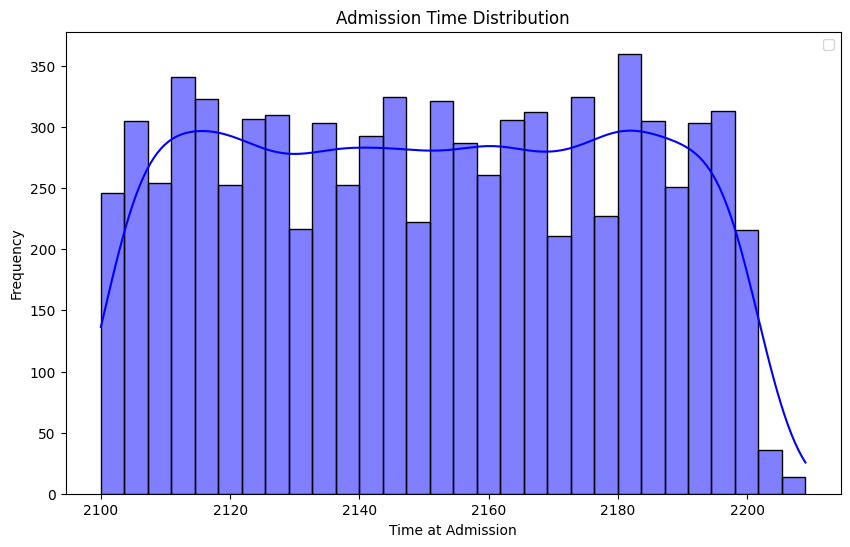

In [25]:
# Histogram of LOS
plt.figure(figsize=(10, 6))
sns.histplot(data['ADMITTIME'], bins=30, kde=True, color='blue')
plt.title('Admission Time Distribution')
plt.xlabel('Time at Admission')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The plot above shows how the Admission Times are limited in a range between 21:00 and 22:00. This reduces the impact on our feature, but we still go for it and encode the information

In [26]:

data_with_dummies['Admission_Hour'] = data_with_dummies['ADMITTIME'].dt.hour
test_with_dummies['Admission_Hour'] = test_with_dummies['ADMITTIME'].dt.hour

# Cyclical Encoding for Hours
data_with_dummies['Hour_Sin'] = np.sin(2 * np.pi * data_with_dummies['Admission_Hour'] / 24)
data_with_dummies['Hour_Cos'] = np.cos(2 * np.pi * data_with_dummies['Admission_Hour'] / 24)

test_with_dummies['Hour_Sin'] = np.sin(2 * np.pi * test_with_dummies['Admission_Hour'] / 24)
test_with_dummies['Hour_Cos'] = np.cos(2 * np.pi * test_with_dummies['Admission_Hour'] / 24)


data_with_dummies.drop(columns=['ADMITTIME', 'Admission_Hour'], inplace=True)
test_with_dummies.drop(columns=['ADMITTIME', 'Admission_Hour'], inplace=True)

## MISSING DATA.

In [27]:
print(data_with_dummies.shape)
print(data_with_dummies.iloc[:,:30].isnull().sum()
      )

(8000, 43)
subject_id                  0
hadm_id                     0
icustay_id                  0
HeartRate_Mean            833
SysBP_Mean                840
DiasBP_Mean               840
MeanBP_Mean               833
RespRate_Mean             833
TempC_Mean                946
SpO2_Mean                 841
Glucose_Mean               98
LOS                         0
Age_0-19                    0
Age_20-39                   0
Age_40-59                   0
Age_60-79                   0
Age_80+                     0
HeartRate_Range           833
SysBP_Range               840
DiasBP_Range              840
MeanBP_Range              833
RespRate_Range            833
TempC_Range               946
SpO2_Range                841
Glucose_Range              98
Private_Insurance           0
Insurance_Group_Public      0
Gender_F                    0
Gender_M                    0
CareUnit_CCU                0
dtype: int64


Seeing that no column has over 15% of Nan's, we will not drop any of them, but rather fill the gaps with different methods.

### METHOD 1

For Glucose levels, because there are very few missing rows, we will simply fill them with the mean of the other values, which will not significantly deviate  the variance

In [28]:

glucose_columns = ['Glucose_Range', 'Glucose_Mean']

# Initialize the imputer for mean imputation
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fit the imputer on the glucose columns and transform them
data_glucose_imputed = imp_mean.fit_transform(data_with_dummies[glucose_columns])
test_glucose_imputed = imp_mean.fit_transform(test_with_dummies[glucose_columns])

# Convert the result back to a DataFrame and assign it back to the original columns
data_with_dummies[glucose_columns] = pd.DataFrame(data_glucose_imputed, columns=glucose_columns)
test_with_dummies[glucose_columns] = pd.DataFrame(test_glucose_imputed, columns=glucose_columns)


To fill the rest of the missing data, the best approach we find is to run a linear regression or a knn taking the age and gender into account, which we consider will affect most for remaining variables such as heart rate, respiration rate, etc.

### METHOD 2

A linear regression imputation taking all other columns into account would be impossible because most of the columns have missing values themselves, which makes it impossible to, for instance, impute heart rate regressing it on other variables such as respiration rate.

Therefore, we run a median imputer.

In [29]:
# Step 1: Identify numerical columns
numerical_columns = data_with_dummies.select_dtypes(include=['number']).columns
test_numerical_columns = test_with_dummies.select_dtypes(include=['number']).columns
# Step 2: Initialize the median imputer
median_imputer = SimpleImputer(strategy='median')

# Step 3: Apply the imputer only to numerical columns
data_with_dummies[numerical_columns] = median_imputer.fit_transform(data_with_dummies[numerical_columns])
test_with_dummies[test_numerical_columns] = median_imputer.fit_transform(test_with_dummies[test_numerical_columns])

In [30]:
print(data_with_dummies.shape)
data_with_dummies.iloc[:,:38].isnull().sum()

(8000, 43)


subject_id                  0
hadm_id                     0
icustay_id                  0
HeartRate_Mean              0
SysBP_Mean                  0
DiasBP_Mean                 0
MeanBP_Mean                 0
RespRate_Mean               0
TempC_Mean                  0
SpO2_Mean                   0
Glucose_Mean                0
LOS                         0
Age_0-19                    0
Age_20-39                   0
Age_40-59                   0
Age_60-79                   0
Age_80+                     0
HeartRate_Range             0
SysBP_Range                 0
DiasBP_Range                0
MeanBP_Range                0
RespRate_Range              0
TempC_Range                 0
SpO2_Range                  0
Glucose_Range               0
Private_Insurance           0
Insurance_Group_Public      0
Gender_F                    0
Gender_M                    0
CareUnit_CCU                0
CareUnit_CSRU               0
CareUnit_MICU               0
CareUnit_SICU               0
CareUnit_T

In [31]:
data_with_dummies.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Mean', 'SysBP_Mean',
       'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean', 'TempC_Mean',
       'SpO2_Mean', 'Glucose_Mean', 'LOS', 'Age_0-19', 'Age_20-39',
       'Age_40-59', 'Age_60-79', 'Age_80+', 'HeartRate_Range', 'SysBP_Range',
       'DiasBP_Range', 'MeanBP_Range', 'RespRate_Range', 'TempC_Range',
       'SpO2_Range', 'Glucose_Range', 'Private_Insurance',
       'Insurance_Group_Public', 'Gender_F', 'Gender_M', 'CareUnit_CCU',
       'CareUnit_CSRU', 'CareUnit_MICU', 'CareUnit_SICU', 'CareUnit_TSICU',
       'average_LOS', 'comorbidity_encoded_mean', 'comorbidity_encoded_sum',
       'comorbidity_encoded_max', 'combined_encoded', 'ICD9_frequency',
       'ICD9_count', 'Hour_Sin', 'Hour_Cos'],
      dtype='object')

before fitting any method, we must standardize some features. We will standardize those with numerical continuous values. 

In [32]:
# Define the list of continuous numerical columns to standardize
columns_to_standardize = [
    'HeartRate_Mean', 'SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean',
    'TempC_Mean', 'SpO2_Mean', 'Glucose_Mean', 'HeartRate_Range', 'SysBP_Range',
    'DiasBP_Range', 'MeanBP_Range', 'RespRate_Range', 'TempC_Range', 'SpO2_Range',
    'Glucose_Range', 'ICD9_count'
]

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply the scaler to the selected columns
data_with_dummies[columns_to_standardize] = scaler.fit_transform(data_with_dummies[columns_to_standardize])
test_with_dummies[columns_to_standardize] = scaler.fit_transform(test_with_dummies[columns_to_standardize])


Finally we drop some data that is not relevant for the model fitting

In [33]:
data_with_dummies.drop(columns=['subject_id', 'hadm_id', 'icustay_id'], inplace=True)
test_with_dummies.drop(columns=['subject_id', 'hadm_id', 'icustay_id'], inplace=True)

# MODEL FITTING

Once all data is ready to be fitted into a model, we first separate the training data into X and Y

In [34]:
# Split data_no_missing into features and target
X_train = data_with_dummies.drop(columns=['LOS'])
y_train = data_with_dummies['LOS']

In [35]:
X_train.shape

(8000, 39)

Our first model will be the **AdaBoostRegressor**. Beforehand, we perform a Randomized Search with CV to get a grasp of what our best hyperparameter values will be, and then a GridSearch to tune them, with a DecisionTreeRegressor as the base estimator. In this way we avoid overfitting, and get closer to the best accuracy

In [36]:
from sklearn.model_selection import RandomizedSearchCV

# Define revised parameter grid
param_distributions = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'estimator__max_depth': [3, 5, 7]
}
tree1 = AdaBoostRegressor(estimator=DecisionTreeRegressor(), random_state=42)
# RandomizedSearchCV for efficiency
random_search = RandomizedSearchCV(
    estimator=tree1,
    param_distributions=param_distributions,
    scoring='neg_root_mean_squared_error',
    n_iter=10,  # Test 10 random combinations
    cv=3,  # Reduce CV folds
    random_state=42,
    n_jobs=-1
)

# Fit and evaluate
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)
print("Best RMSE:", -random_search.best_score_)


Best Parameters: {'n_estimators': 50, 'learning_rate': 0.1, 'estimator__max_depth': 7}
Best RMSE: 3.507651317751931


In [37]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [40, 50,70],
    'learning_rate': [0.05,  0.1,0.2],
    'estimator__max_depth': [ 7 ,9,11]
}

tree1 = AdaBoostRegressor(estimator=DecisionTreeRegressor(), random_state=42)
grid_search = GridSearchCV(tree1, param_grid, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)

/home/alexmalo/.pyenv/versions/3.11.10/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'estimator__max_depth': 11, 'learning_rate': 0.1, 'n_estimators': 70}
Best RMSE: 3.288427785641237


In [38]:
tree = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=9), n_estimators=70,learning_rate= 0.1, random_state=42)

scores = cross_val_score(tree, X_train, y_train, cv=5,  scoring='neg_root_mean_squared_error')
print(scores)
print(scores.mean())

[-3.31795655 -3.06880652 -3.20126606 -3.52732421 -3.45563675]
-3.3141980179247454


In [39]:
tree.fit(X_train, y_train)
# Predict the target values for X_test
y_AdaBoost = tree.predict(test_with_dummies)

Our initial action is to explore multiple methods and their results. f

In [40]:
state = 42

# Function to generate models
def get_models():
    # Generate a library of regression learners
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=state, min_samples_leaf=5)
    gbr = GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=state)
    lgbm = LGBMRegressor(n_estimators=100, random_state=state)
    ridge = Ridge(alpha=1.0, random_state=state)
    lasso = Lasso(alpha=0.01, random_state=state)

    models = {
        'Random Forest': rf,
        'Gradient Boosting': gbr,
        'LightGBM': lgbm,
        'Ridge Regression': ridge,
        'Lasso Regression': lasso,
    }
    return models

# Train and predict function
def train_predict(models, xtrain, ytrain):
    # Fit models on training set and return predictions
    P = pd.DataFrame(index=xtrain.index)
    cols = []

    for name, model in models.items():
        print(f"Training {name}...", end=" ", flush=True)
        model.fit(xtrain, ytrain)
        P[name] = model.predict(xtrain)  # Predict on training set
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done training models.\n")
    return P

# THis function evaluates each model using cross-validation
def score_models(models, xtrain, ytrain):
    print("Scoring models with cross-validation.")
    scores = {}
    for name, model in models.items():
        cv_scores = cross_val_score(model, xtrain, ytrain, scoring='neg_mean_squared_error', cv=5)  # 5-fold CV
        mean_score = np.mean(cv_scores)
        scores[name] = mean_score
        print(f"{name:25s}: RMSE = {mean_score:.3f}")
    return scores


models = get_models()
predictions = train_predict(models, X_train, y_train)
scores = score_models(models, X_train, y_train)

print("\nModel Performance Summary:")
for name, score in scores.items():
    print(f"{name:25s}: RMSE = {score:.3f}")


Training Random Forest... 

done
Training Gradient Boosting... done
Training LightGBM... [LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4797
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 37
[LightGBM] [Info] Start training from score 3.772353
done
Training Ridge Regression... done
Training Lasso Regression... done
Done training models.

Scoring models with cross-validation.
Random Forest            : RMSE = -11.105
Gradient Boosting        : RMSE = -10.925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4754
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 37
[LightGBM] [Info] Start training from score 3.770059
[LightGBM] [Info] Auto-choosing col-wis

DESPITE THE RMSE VALUES BEING VERY HIGH (DUE TO BAD PRIORS ON THE HYPERPARAMETERS), WE FIND RANDOM FOREST, GRADIENT BOOSTING AND LIGHTGBM TO BE THE BEST, SO WE WILL FURTHER STUDY THEM

TO STUDY THE LIGHTGBM MODEL, WE PERFORM A **RandomizedSearchCV** THAT WILL GIVE US INSIGHTS ON WHAT THE BEST PARAMETERS ARE

In [48]:
lgb_model = lgb.LGBMRegressor(random_state=42)

# Hyperparameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [ 200, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 10],
    'num_leaves': [31, 50],
    'min_child_samples': [10, 20]
}
# RandomizedSearchCV for LightGBM
random_search_lgb = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_dist, n_iter=32, cv=3,
                                       scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)
random_search_lgb.fit(X_train, y_train)

# Best hyperparameters and performance
print("Best hyperparameters:", random_search_lgb.best_params_)
print("Best RMSE (CV):", np.abs(random_search_lgb.best_score_))

# Predict with best model
best_lgb_model = random_search_lgb.best_estimator_
y_pred_lgb = best_lgb_model.predict(X_train)

# Calculate RMSE on training data
rmse_lgb = np.sqrt(root_mean_squared_error(y_train, y_pred_lgb))
print("RMSE on training set:", rmse_lgb)

/home/alexmalo/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 32 is smaller than n_iter=50. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4738
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4724
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4715
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4715
[LightGBM] [Info] Number of data points in the train set: 5334, number of used features:

In [53]:
light = lgb.LGBMRegressor(num_leaves=31,n_estimators =200,min_child_samples=10,max_depth=5,learning_rate=0.1)

scores = cross_val_score(light, X_train, y_train, cv=5,  scoring='neg_root_mean_squared_error')
print(scores)
print(scores.mean())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4754
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 37
[LightGBM] [Info] Start training from score 3.770059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [54]:
light.fit(X_train, y_train)

# Predict the target values for X_test
y_pred_light = light.predict(test_with_dummies)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4797
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 37
[LightGBM] [Info] Start training from score 3.772353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Now we proceed to do an equivalent search for RandomForest

In [56]:
rf_model = RandomForestRegressor(random_state=42)

# Hyperparameter grid for RandomizedSearchCV
param_dist_rf = {
    'n_estimators': [150, 200, 220],
    'max_depth': [5, 35, None],
    'min_samples_split': [1,2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [ 'sqrt'],
}
#param_dist_rf = {
 #   'n_estimators': [150, 200, 220],
  #  'max_depth': [5, 35, None],
   # 'min_samples_split': [1,2, 5],
    #'min_samples_leaf': [1, 2, 4],
    #'max_features': ['auto', 'sqrt', 'log2'],

# RandomizedSearchCV for RandomForest
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist_rf, n_iter=50,
                                      cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)
random_search_rf.fit(X_train, y_train)

# Best hyperparameters and performance
print("Best hyperparameters:", random_search_rf.best_params_)
print("Best RMSE (CV):", np.abs(random_search_rf.best_score_))

# Predict with best model
best_rf_model = random_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_train)

# Calculate RMSE on training data
rmse_rf = np.sqrt(root_mean_squared_error(y_train, y_pred_rf))
print("RMSE on training set:", rmse_rf)


/home/alexmalo/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
85 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
85 fits failed with the following error:
Traceback (most recent call last):
  File "/home/alexmalo/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/alexmalo/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/alexmalo/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/base.py", line 666, in _va

Best hyperparameters: {'n_estimators': 220, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Best RMSE (CV): 3.4289959044205687
RMSE on training set: 1.2627520659448297


In [66]:
forest = RandomForestRegressor(max_depth=None,n_estimators =200, min_samples_split =2, min_samples_leaf=2 ,max_features ='sqrt')

scores = cross_val_score(forest, X_train, y_train, cv=5,  scoring='neg_root_mean_squared_error')
print(scores)
print(scores.mean())

[-3.36484874 -3.10684551 -3.26634014 -3.81471905 -3.59683716]
-3.42991812138442


In [ ]:
forest.fit(X_train, y_train)
y_pred_forest = forest.predict(test_with_dummies)

## ENSEMBLING

Given our top candidates, the final procedure consists in trying to ensemble the models, looking for even better results. Our first approach will be stacking and second will be blending.

### STACKING

In [80]:
base_models = [
    ('random_forest',RandomForestRegressor(max_depth=None,n_estimators =200, min_samples_split =5, min_samples_leaf=1 ,max_features ='sqrt')),
    ('lightgbm', lgb.LGBMRegressor(num_leaves=31,n_estimators =200,min_child_samples=10,max_depth=5,learning_rate=0.05))
]

# Meta-model
meta_model = Ridge(alpha=1.0)

# Stacking Regressor
stacked_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

# Train the stacked model
stacked_model.fit(X_train, y_train)

# Predict and evaluate performance
y_pred_stacked = stacked_model.predict(X_train)
rmse_stacked = np.sqrt(root_mean_squared_error(y_train, y_pred_stacked))
print("RMSE on training set (stacking):", rmse_stacked)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4797
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 37
[LightGBM] [Info] Start training from score 3.772353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [81]:
# Predict the target values for X_test
y_pred_stacked_model = stacked_model.predict(test_with_dummies)

### BLENDING

Now we must also define the weights each models gets. Because Random Forest gets much better results, we give it a more significant weight

In [86]:
# Split training set into blending train and validation parts
X_blend_train, X_blend_valid, y_blend_train, y_blend_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Base models
rf_model = RandomForestRegressor(max_depth=None,n_estimators =200, min_samples_split =2, min_samples_leaf=2 ,max_features ='sqrt')
lgb_model = lgb.LGBMRegressor(num_leaves=31,n_estimators =300,min_child_samples=20,max_depth=10,learning_rate=0.05)

# Train base models
rf_model.fit(X_blend_train, y_blend_train)
lgb_model.fit(X_blend_train, y_blend_train)

# Generate predictions on validation set
rf_preds = rf_model.predict(X_blend_valid)
lgb_preds = lgb_model.predict(X_blend_valid)

# Blend predictions (weighted average)
blended_preds = 0.6 * rf_preds + 0.4 * lgb_preds

# Evaluate blended predictions
rmse_blended = np.sqrt(root_mean_squared_error(y_blend_valid, blended_preds))
print("RMSE on blending validation set:", rmse_blended)

# Use entire training set for final models and blend
rf_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)

rf_final_preds = rf_model.predict(X_train)
lgb_final_preds = lgb_model.predict(X_train)
final_blended_preds = 0.7 * rf_final_preds + 0.3 * lgb_final_preds

# Final RMSE on the training set
rmse_final_blended = np.sqrt(root_mean_squared_error(y_train, final_blended_preds))
print("Final RMSE on training set (blending):", rmse_final_blended)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4755
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 37
[LightGBM] [Info] Start training from score 3.739050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [93]:
rf_final_preds = rf_model.predict(test_with_dummies)
lgb_final_preds = lgb_model.predict(test_with_dummies)
final_blended_preds = 0.85 * rf_final_preds + 0.15 * lgb_final_preds

#### ALL IN ALL, THE BEST RESULTS COME FROM RANDOM FOREST, AND SIMILAR RESULTS ARE ACHIEVED BY BLENDING RANDOM FOREST WITH LIGHTGBM.

In [94]:
# Produce .csv for kaggle testing
test_predictions_submit = pd.DataFrame({"icustay_id": test["icustay_id"], "LOS": final_blended_preds})
test_predictions_submit.to_csv("test_predictions_submit.csv", index = False)